In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sealsml.data import GeoCalculator, DataSampler

In [17]:
class DataSampler(object):
    """ Sample LES data with various geometric configurations. """

    def __init__(self, min_trace_sensors=3, max_trace_sensors=15, min_leak_loc=1, max_leak_loc=10,
                 sensor_height=3, resolution=2,
                 coord_vars=["ref_distance", "ref_azi_sin", "ref_azi_cos", "ref_elv"],
                 met_vars=['u', 'v', 'w'], emission_vars=['q_CH4']):

        self.min_trace_sensors = min_trace_sensors
        self.max_trace_sensors = max_trace_sensors
        self.min_leak_loc = min_leak_loc
        self.max_leak_loc = max_leak_loc
        self.sensor_height = sensor_height
        self.resolution = resolution
        self.coord_vars = coord_vars
        self.met_vars = met_vars
        self.emission_vars = emission_vars
        self.variables = coord_vars + met_vars + emission_vars
        self.n_new_vars = len(coord_vars)
        self.met_loc_mask = np.isin(self.variables, self.emission_vars) * 1
        self.ch4_mask = np.isin(self.variables, self.met_vars) * 1

    def load_data(self, file_names):

        """ load xarray datasets from a list of file names. """

        self.data = xr.open_mfdataset(file_names, parallel=True).swap_dims({'time': 'timeDim'}).load()
        self.time_steps = len(self.data['timeDim'].values)
        self.iDim = len(self.data.iDim)
        self.jDim = len(self.data.jDim)
        # add zero arrays for new derived variables
        for var in self.coord_vars:
            self.data[var] = (["kDim", "jDim", "iDim"], np.zeros(shape=(len(self.data.kDim),
                                                                        len(self.data.jDim),
                                                                        len(self.data.iDim))))

    def sample(self, time_window_size, samples_per_window, window_stride=5):

        """  Sample different geometric configurations of sensors from LES data for ML ingestion.
        Args:
            time_window_size (int): Length of timeseries (index based) for each sample.
            samples_per_window (int): Number of samples to draw from each time window.
            window_stride (int): stride width to slide window through time (index based)
        Returns:
            sensor_array, potential_leak_array: Numpy Arrays of shape (sample, sensor, time, variable) """

        sensor_arrays, leak_arrays = [], []

        indexes = {} # added for plotting here only
        for name in ['rp', 'i_sensor', 'j_sensor', 'i_leak', 'j_leak']:
            indexes[name] = []
        
        geom_calc = GeoCalculator()

        for t in np.arange(0, self.time_steps - time_window_size, window_stride):
            print(t)
            for _ in range(samples_per_window):

                n_sensors = np.random.randint(low=self.min_trace_sensors, high=self.max_trace_sensors)
                n_leaks = np.random.randint(low=self.min_leak_loc, high=self.max_leak_loc)
                true_leak_pos = 0

                reference_point = np.random.randint(low=0, high=self.iDim, size=3)
                reference_point[-1] = self.sensor_height
                true_leak_i, true_leak_j = 15, 15

                i_sensor = np.random.randint(low=0, high=self.iDim, size=n_sensors)
                j_sensor = np.random.randint(low=0, high=self.jDim, size=n_sensors)
                i_leak = np.random.randint(low=0, high=self.iDim, size=n_leaks)
                j_leak = np.random.randint(low=0, high=self.jDim, size=n_leaks)
                i_leak[true_leak_pos] = true_leak_i  # set one of the potential leaks to the true position
                j_leak[true_leak_pos] = true_leak_j
                k = self.sensor_height
                sensor_idx = np.stack([i_sensor, j_sensor, np.repeat(k, n_sensors)]).T
                leak_idx = np.stack([i_leak, j_leak, np.repeat(k, n_leaks)]).T

                sensor_sample = self.data[self.variables].to_array().expand_dims('sample').values[:, :,
                                k, j_sensor, i_sensor, t:t + time_window_size]
                leak_sample = self.data[self.variables].to_array().expand_dims('sample').values[:, :,
                                k, j_leak, i_leak, t + time_window_size: t + time_window_size + 1]

                derived_sensor_vars = geom_calc.get_geometry(reference_point, sensor_idx, self.resolution)
                derived_leak_vars = geom_calc.get_geometry(reference_point, leak_idx, self.resolution)

                expanded_vars = np.transpose(np.broadcast_to(derived_sensor_vars,
                                                             shape=(time_window_size,
                                                                    derived_sensor_vars.shape[0],
                                                                    self.n_new_vars)), axes=[2, 1, 0])
                sensor_sample[0, :self.n_new_vars, :] = expanded_vars
                sensor_sample = self.create_mask(sensor_sample, kind="sensor")
                leak_sample[0, :self.n_new_vars, :, 0] = derived_leak_vars.T
                leak_sample = self.create_mask(leak_sample, kind="leak")

                padded_sensor_sample = self.pad_along_axis(sensor_sample, target_length=self.max_trace_sensors,
                                                           pad_value=0, axis=2)
                padded_leak_sample = self.pad_along_axis(leak_sample, target_length=self.max_leak_loc,
                                                         pad_value=0, axis=2)

                sensor_arrays.append(padded_sensor_sample)
                leak_arrays.append(padded_leak_sample)

                # added for plotting verification
                indexes['rp'].append(reference_point)
                indexes['i_sensor'].append(i_sensor)
                indexes['j_sensor'].append(j_sensor)
                indexes['i_leak'].append(i_leak)
                indexes['j_leak'].append(j_leak)

        sensor_samples = np.transpose(np.vstack(sensor_arrays), axes=[0, 2, 1, 3, 4]) # order [sample, sensor, time, var]
        leak_samples = np.transpose(np.vstack(leak_arrays), axes=[0, 2, 1, 3, 4])

        return sensor_samples, leak_samples, indexes

    def pad_along_axis(self, array, target_length, pad_value=0, axis=0):
        """ Pad numpy array along a single dimension. """
        pad_size = target_length - array.shape[axis]
        if pad_size <= 0:
            return array

        n_pad = [(0, 0)] * array.ndim
        n_pad[axis] = (0, pad_size)

        return np.pad(array, pad_width=n_pad, mode='constant', constant_values=pad_value)

    def create_mask(self, array, kind):

        array = np.transpose(array, axes=[0, 3, 2, 1])  # reshape for proper broadcasting
        mask_2d = np.zeros(shape=(array.shape[-2], array.shape[-1]))

        if kind == "sensor":

            mask_2d[0] = self.met_loc_mask  # make the first random sensor the "met sensor"
            mask_2d[1:] = self.ch4_mask     # all others don't have met data

        elif kind == "leak":

            mask_2d[:] = self.ch4_mask

        expanded_mask = np.broadcast_to(mask_2d, array.shape)
        array_w_mask = np.stack(arrays=[array, expanded_mask], axis=-1)

        return np.transpose(array_w_mask, axes=[0, 1, 2, 3, 4])

    def create_targets(self, decoder_x):
        """ Create target data from potential leak arrays. Outputs both concentrations and categorical (argmax)"""
        q_CH4_concentration = decoder_x[:, :, :, -1]
        q_CH4_catergorical = (q_CH4_concentration == q_CH4_concentration.max(axis=1)[:, None]).astype(int)

        return q_CH4_concentration, q_CH4_catergorical

    def make_xr_da(self, encoder_x, decoder_x):
        """ Convert numpy arrays from .sample() to xarray Arrays. """

        encoder_ds = xr.DataArray(encoder_x,
                                  dims=['sample', 'sensor', 'time', 'variable', 'mask'],
                                  coords={'variable': ["ref_distance", "ref_azi_sin", "ref_azi_cos", "ref_elv",
                                          "u", "v", "w", "q_CH4"]})
        decoder_ds = xr.DataArray(decoder_x,
                                  dims=['sample', 'pot_leak', 'time', 'variable', 'mask'],
                                  coords={'variable': ["ref_distance", "ref_azi_sin", "ref_azi_cos", "ref_elv",
                                          "u", "v", "w", "q_CH4"]})

        return encoder_ds, decoder_ds

In [18]:
files = ["../data/SET_09_12_23/FE_CBL2m_Ug10.6"]
sampler = DataSampler(min_trace_sensors=4, max_trace_sensors=10, min_leak_loc=3, max_leak_loc=5,
                      sensor_height=5, resolution=2, coord_vars=["ref_distance", "ref_azi_sin", "ref_azi_cos", "ref_elv"],
                      met_vars=['u', 'v', 'w'], emission_vars=['q_CH4'])
sampler.load_data(files)
sampler.data

<xarray.Dataset>
Dimensions:                (timeDim: 361, srcDim: 1, locDim: 3, kDim: 15,
                            jDim: 30, iDim: 30)
Coordinates:
    time                   (timeDim) float64 1.44e+04 1.441e+04 ... 1.62e+04
Dimensions without coordinates: timeDim, srcDim, locDim, kDim, jDim, iDim
Data variables: (12/14)
    srcAuxScLocation       (srcDim, locDim) float64 99.0 2.599e+03 0.5
    srcAuxScMassSpecValue  (srcDim) float64 10.0
    structureMask          (kDim, jDim, iDim) float64 0.0 0.0 0.0 ... 0.0 0.0
    xPos                   (kDim, jDim, iDim) float32 69.0 71.0 ... 125.0 127.0
    yPos                   (kDim, jDim, iDim) float32 2.569e+03 ... 2.627e+03
    zPos                   (kDim, jDim, iDim) float32 1.0 1.0 ... 30.65 30.65
    ...                     ...
    w                      (timeDim, kDim, jDim, iDim) float32 -0.1354 ... 1.028
    q_CH4                  (timeDim, kDim, jDim, iDim) float32 1e-09 ... 3.09...
    ref_distance           (kDim, jDim, iDim) float64 0.0 0.0 0.0 ... 0.0 0.0
    ref_azi_sin            (kDim, jDim, iDim) float64 0.0 0.0 0.0 ... 0.0 0.0
    ref_azi_cos            (kDim, jDim, iDim) float64 0.0 0.0 0.0 ... 0.0 0.0
    ref_elv                (kDim, jDim, iDim) float64 0.0 0.0 0.0 ... 0.0 0.0

In [19]:
samples_per_window = 3
time_window_size = 100
window_stride = 10
encoder_x, decoder_x, indexes = sampler.sample(time_window_size=time_window_size, samples_per_window=samples_per_window, window_stride=window_stride)

0
Warning, Azimuth Calculation might be wrong for vertically offset points
10
20
Warning, Azimuth Calculation might be wrong for vertically offset points
30
40
50
60
Warning, Azimuth Calculation might be wrong for vertically offset points
70
80
90
100
110
120
130
140
150
160
170
Warning, Azimuth Calculation might be wrong for vertically offset points
180
190
200
Warning, Azimuth Calculation might be wrong for vertically offset points
210


/Users/cbecker/miniconda3/envs/seals/lib/python3.10/site-packages/sealsml/geometry.py:164: RuntimeWarning: invalid value encountered in divide
  dip_radians = np.arcsin(dz / distance)


220
230
240
250
260


In [20]:
# [sample, sensor, time, variable] 
encoder_x.shape, decoder_x.shape

((81, 10, 100, 8, 2), (81, 5, 1, 8, 2))

In [21]:
target_val, target_cat = sampler.create_targets(decoder_x)
target_val.shape

(81, 5, 1, 2)

In [22]:
encoder_ds, decoder_ds = sampler.make_xr_da(encoder_x, decoder_x)
encoder_ds

<xarray.DataArray (sample: 81, sensor: 10, time: 100, variable: 8, mask: 2)>
array([[[[[ 4.95176736e+01,  0.00000000e+00],
          [-6.86623533e-01,  0.00000000e+00],
          [-7.27013153e-01,  0.00000000e+00],
          ...,
          [ 8.58169496e-01,  0.00000000e+00],
          [ 4.61298943e-01,  0.00000000e+00],
          [ 9.99999972e-10,  1.00000000e+00]],

         [[ 4.95176736e+01,  0.00000000e+00],
          [-6.86623533e-01,  0.00000000e+00],
          [-7.27013153e-01,  0.00000000e+00],
          ...,
          [ 1.48697937e+00,  0.00000000e+00],
          [ 4.38846618e-01,  0.00000000e+00],
          [ 9.99999972e-10,  1.00000000e+00]],

         [[ 4.95176736e+01,  0.00000000e+00],
          [-6.86623533e-01,  0.00000000e+00],
          [-7.27013153e-01,  0.00000000e+00],
          ...,
...
          ...,
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00]]]]])
Coordinates:
  * variable  (variable) <U12 'ref_distance' 'ref_azi_sin' ... 'w' 'q_CH4'
Dimensions without coordinates: sample, sensor, time, mask

47
150


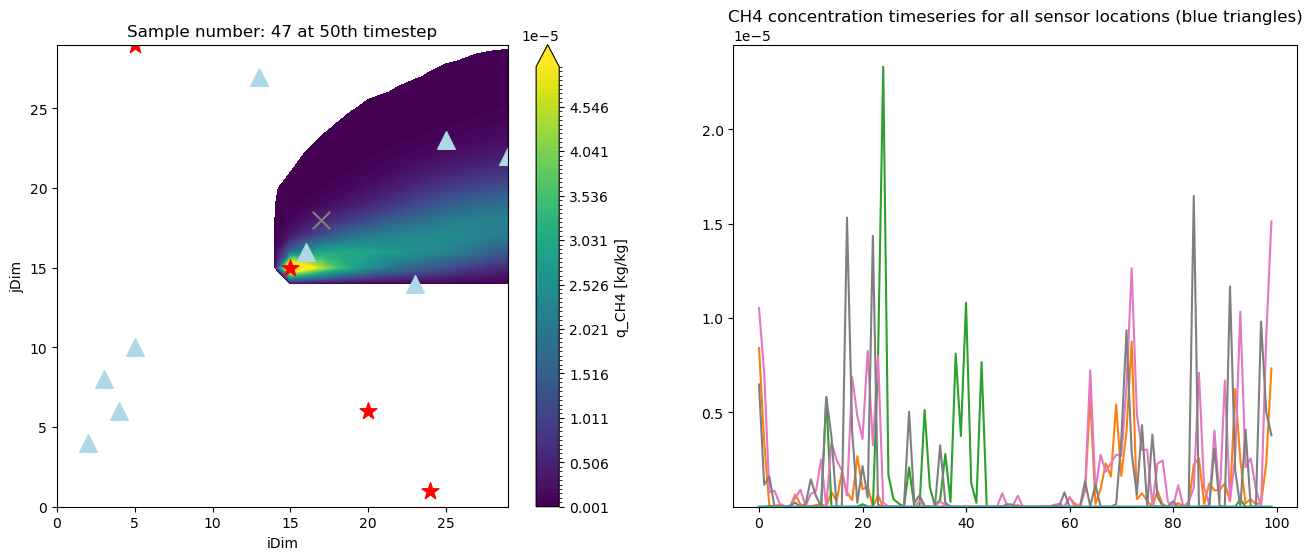

26
80


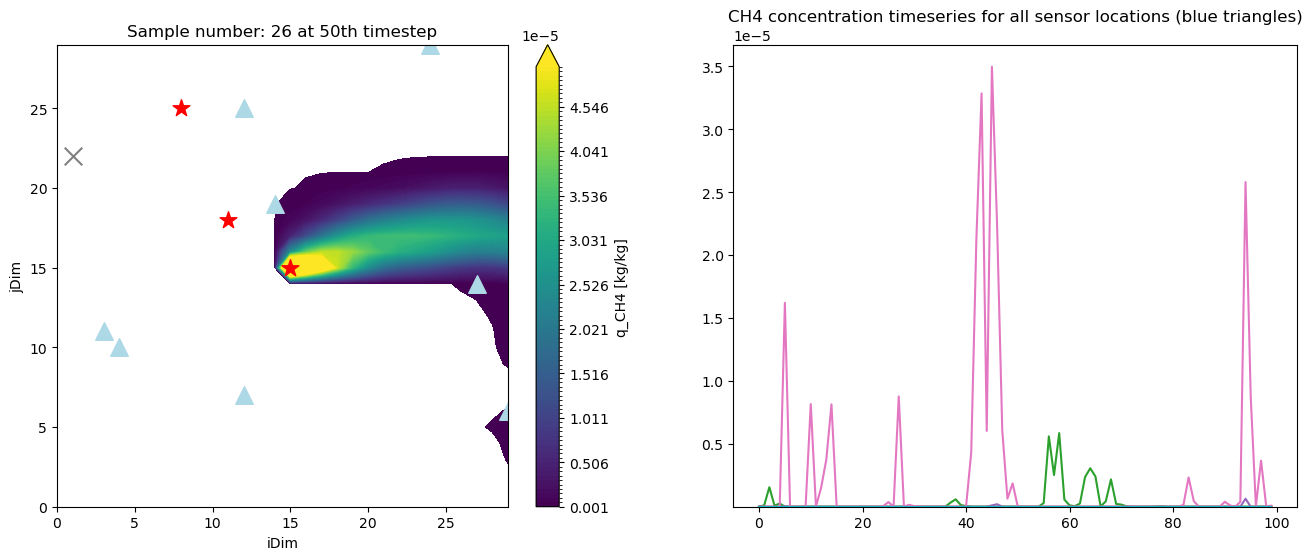

24
80


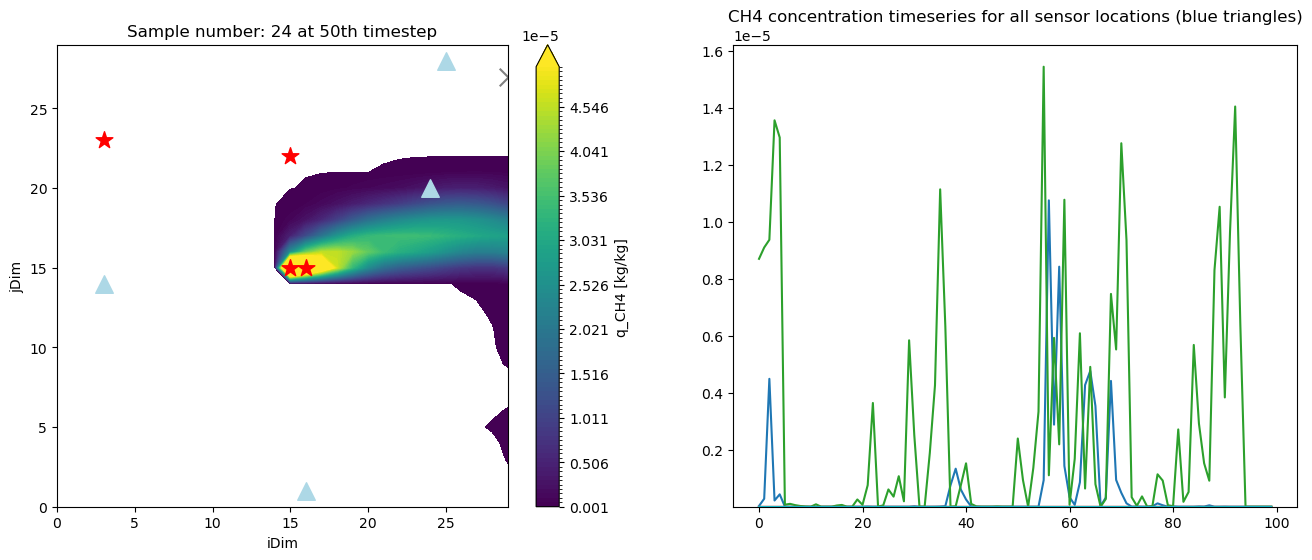

24
80


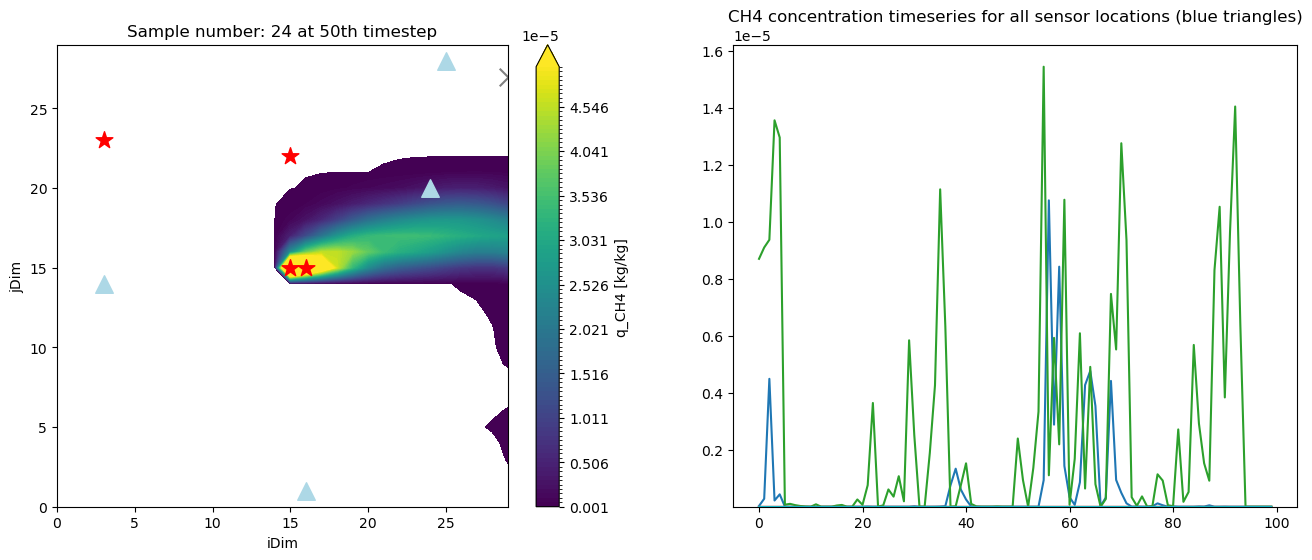

72
240


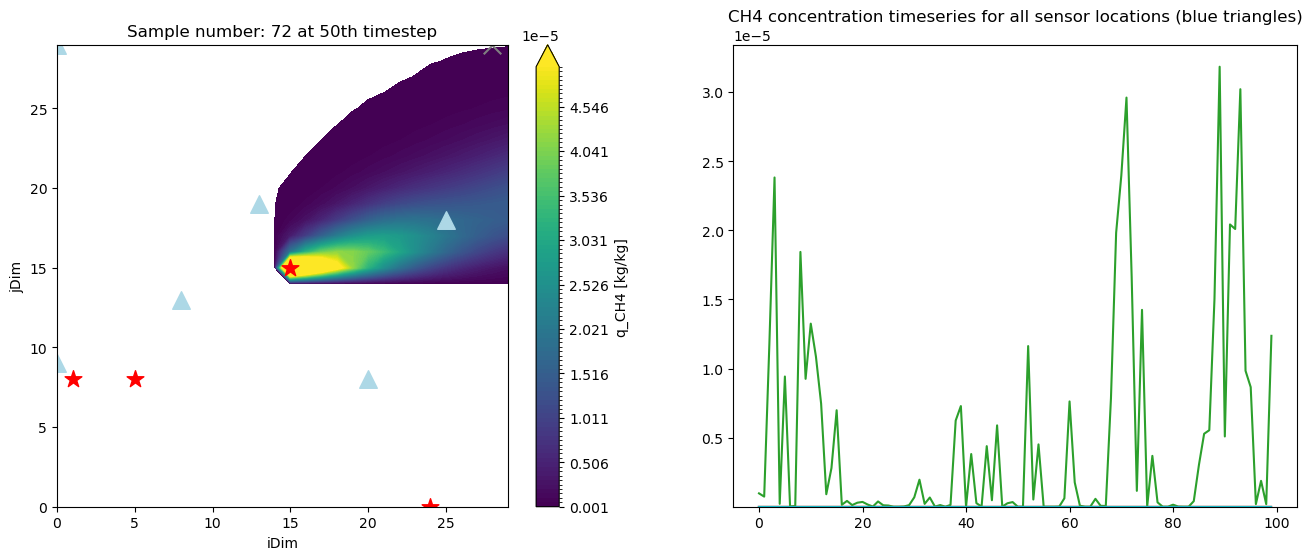

In [24]:
for _ in range(5):
    sample = np.random.randint(0, encoder_x.shape[0], 1)[0]
    print(sample)
    init_sample_timestep = sample // samples_per_window * window_stride
    print(init_sample_timestep)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    sampler.data['q_CH4'][init_sample_timestep + 50, 3].plot.contourf(levels=np.linspace(1e-8, 0.00005, 100), ax=ax[0], extend='max')
    ax[0].set_title(f'Sample number: {sample} at 50th timestep')
    ax[0].scatter(indexes['i_sensor'][sample], indexes['j_sensor'][sample], s=160, marker="^", color='lightblue')
    ax[0].scatter(indexes['i_leak'][sample], indexes['j_leak'][sample], s=160, marker='*', color='r')
    ax[0].scatter(indexes['rp'][sample][0], indexes['rp'][sample][1], s=160, marker='x', color='grey')
    
    ax[1].plot(encoder_x[sample, :, :, -1, 0].T)
    ax[1].set_ylim(1e-10)
    ax[1].set_title("CH4 concentration timeseries for all sensor locations (blue triangles)")
    plt.show()